## Load Data & Modules

In [39]:
import json 
import pprint
import datetime
import dateutil
import matplotlib.pyplot as plt
import matplotlib.dates as mtdates

# Set size of charts
plt.rcParams["figure.figsize"] =(15,5)

p = pprint.PrettyPrinter(indent=4, compact=True)

# set the file location for price Data
# price_dir = 'btcpf.json'
price_dir = 'eospf.json'

with open(price_dir, encoding = 'utf-8') as data_file:
  data = json.loads(data_file.read())

price_data = data['price_usd']

# set the file location for telegram chat Data
# sent_dir = 'btcSentf.json'
sent_dir = 'eosSentf.json'

with open(sent_dir, encoding = 'utf-8') as data_file:
  data = json.loads(data_file.read())

sent_data = data

print(len(price_data), len(sent_data))

576 12485


## Functions To Process & Plot Data

In [40]:
def getEpochFromTimeStamp(stamp): return dateutil.parser.parse(stamp).timestamp()

def getEpochInSec(epoch):
    if len(str(int(epoch))) != 10: epoch /= 1000
    return epoch

def getTimeStampFromEpoc(epoch):
    return datetime.datetime.fromtimestamp(getEpochInSec(epoch)).strftime('%Y-%m-%d %H:%M:%S')

def getDateObjectFromEpoc(epoch): return dateutil.parser.parse(getTimeStampFromEpoc(epoch))

def getDateObjectFromTimeStamp(stamp): return dateutil.parser.parse(stamp)

def getAvg(arr): return ( sum(arr) / len(arr) )

def getNormalizedPriceData(data): return getAvg(list(map(lambda x: x[1], data)))

def getNormalizedSentimentData(data): return getAvg(list(map(lambda x: x['sentiment']['compound'], data)))

def getNormalizedNegativeSentimentData(data): return getAvg(list(map(lambda x: x['sentiment']['neg'], data)))

def getNormalizedPostiveSentimentData(data): return getAvg(list(map(lambda x: x['sentiment']['pos'], data)))

def getPriceData(data, start, end, step): 
    norm_data = []
    while start < end:        
        p_data = list(filter(lambda x: start < x[0] and x[0] < (start + step), data))

        if len(p_data) > 0: norm_data.append(getNormalizedPriceData(p_data))
        else: norm_data.append(0)
            
        start += step
    
    return norm_data

def getSentimentData(data, start, end, step, sentType): 
    norm_data = []
    while start < end:        
        s_data = list(filter(lambda x: start < x['time_stamp'] and x['time_stamp'] < (start + step), data))
        
        if len(s_data) > 0:
            if sentType == 'com': norm_data.append(getNormalizedSentimentData(s_data))
            if sentType == 'neg': norm_data.append(getNormalizedNegativeSentimentData(s_data))
            if sentType == 'pos': norm_data.append(getNormalizedPostiveSentimentData(s_data))
        else: norm_data.append(0)
            
        start += step
    
    return norm_data

def getVolumeData(data, start, end, step): 
    norm_data = []
    while start < end:        
        s_data = list(filter(lambda x: start < x['time_stamp'] and x['time_stamp'] < (start + step), data))

        if len(s_data) > 0: norm_data.append(len(s_data))
        else: norm_data.append(0)    
            
        start += step
    
    return norm_data

def getTimeData(start, end, step): 
    time_data = []
    while start < end:        
        start += step
        time_data.append(getDateObjectFromEpoc(start))
    
    return time_data

def plotChart(time_data, plot_data, base, color='b', pt=plt):
    pt.plot_date(time_data, plot_data, ms=0)
    pt.plot(time_data, plot_data, color)
    pt.axhline(base, linewidth=1, color='0')
    pt.gcf().autofmt_xdate()
    
    return plt

def getPercentChange(current, base): return ( current / base ) * 100

def normalisedData(base, start, end):
    baseRange = max(base) - min(base)
    finalRange = end - start
    
    return list(map(lambda x: start + ((x - min(base))*finalRange/baseRange), base))

def binaryNormalized(base_data, min_value, max_value, previous_value = 0, pivot=False): 
    norm_data = []
    start_value = base_data[0]
    for current_value in base_data: 
        delta = current_value - start_value
        if delta > 0: 
            norm_data.append(max_value)
            previous_value = max_value
        else: 
            if delta == 0: norm_data.append(previous_value)
            else: 
                norm_data.append(min_value)
                previous_value = min_value
                
        if pivot: start_value = current_value
                
    return norm_data


## Set Best Time Range & Steps

In [41]:
print('price_data :', 
    getTimeStampFromEpoc(price_data[0][0]),
    '-', getTimeStampFromEpoc(price_data[len(price_data) -1][0]))
print('sent_data :',
    getTimeStampFromEpoc(sent_data[0]['time_stamp']), 
    '-', getTimeStampFromEpoc(sent_data[len(sent_data) -1]['time_stamp']))

price_start = getEpochInSec(price_data[0][0])
price_end = getEpochInSec(price_data[len(price_data) -1][0])
sent_start = getEpochInSec(sent_data[0]['time_stamp'])
sent_end = getEpochInSec(sent_data[len(sent_data) -1]['time_stamp'])
tmp_time = price_start

# if data is in reverse order this will make it in correct one

if price_start > price_end: 
    tmp_time = price_start
    price_start = price_end
    price_end = tmp_time
    
if sent_start > sent_end:
    tmp_time = sent_start
    sent_start = sent_end
    sent_end = tmp_time
    
# if data is not in order

tmp_time = list(map(lambda x: x['time_stamp'], sent_data))
sent_start = min(tmp_time)
sent_end = max(tmp_time)

# Set the starting point in time for plotting chart
if price_start > sent_start: start = getTimeStampFromEpoc(price_start)
else: start = getTimeStampFromEpoc(sent_start)
print('start : ', start)
start = getEpochFromTimeStamp(start)
    
# Set the ending point in time for plotting chart
if price_end < sent_end: end = getTimeStampFromEpoc(price_end)
else: end = getTimeStampFromEpoc(sent_end)
print('end : ', end)
end = getEpochFromTimeStamp(end)


# Set the step to display 100 data points
step = (end - start) / 100
print('step : ', step / 3600, 'hr')

price_data : 2017-11-23 05:34:10 - 2017-11-29 05:29:13
sent_data : 2017-11-23 21:22:35 - 2017-11-29 19:23:53
start :  2017-11-23 21:22:35
end :  2017-11-29 05:29:13
step :  1.2811055555555555 hr


## Get Data To Plot Charts

In [42]:
# set the start, end time and step if required

# start = getEpochFromTimeStamp('2017-11-23 23:00:00')
# end = getEpochFromTimeStamp('2017-11-28 23:00:00')
# step = 86400

# Get all the requried data to plot charts
btc_price_data = getPriceData(price_data, start * 1000, end * 1000, step * 1000)
btc_chat_sent_data = getSentimentData(sent_data, start, end, step, 'neg')
message_volume_data = getVolumeData(sent_data, start, end, step)
time_data = mtdates.date2num(getTimeData(start, end, step))

# Set min and max for the loaded data
btc_price_min = min(btc_price_data) 
btc_price_max = max(btc_price_data) 
btc_chat_sent_min = min(btc_chat_sent_data) 
btc_chat_sent_max = max(btc_chat_sent_data) 
btc_chat_volume_min = min(message_volume_data) 
btc_chat_volume_max = max(message_volume_data) 

if btc_chat_volume_min == 0: btc_chat_volume_min = 1

print(len(btc_price_data), len(btc_chat_sent_data), len(message_volume_data), len(time_data))

100 100 100 100


## Coin Price
  - This chart show the price of coin across time

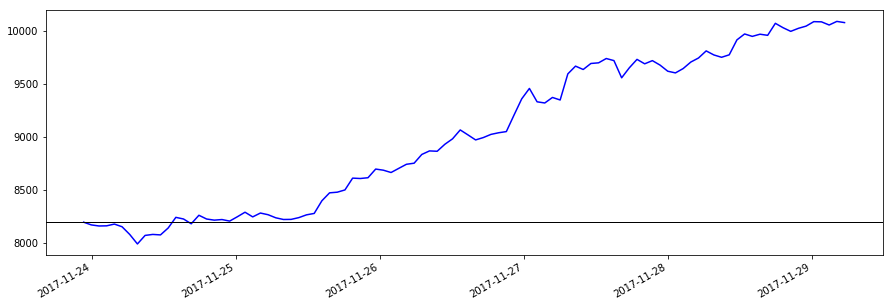

In [43]:
plotChart(time_data, btc_price_data, btc_price_data[0]).show()

## Coin Sentiment
  - This chart show the sentiment of coin across time

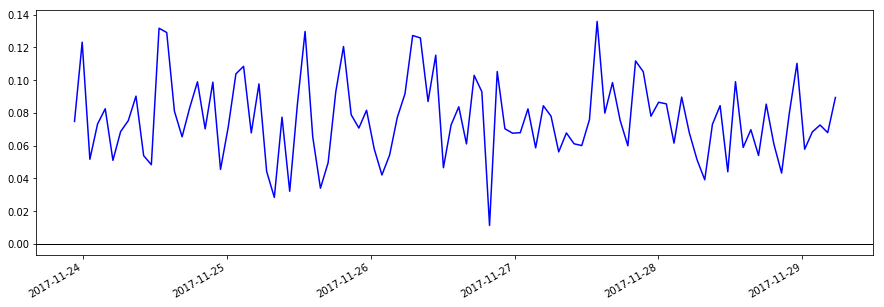

In [44]:
plotChart(time_data, btc_chat_sent_data, 0).show()

## Message Volume
  - This chart show the volume of messages across time

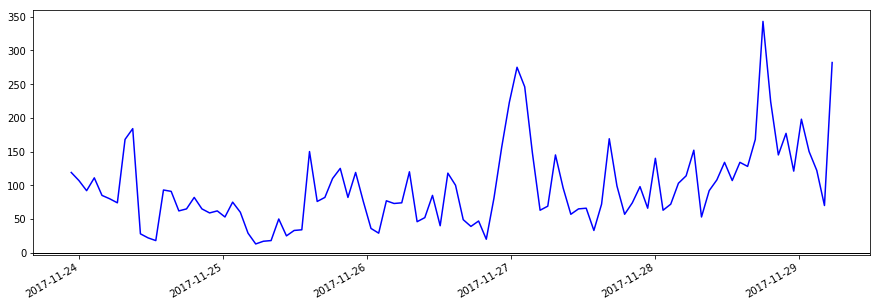

In [45]:
plotChart(time_data, message_volume_data, 0).show()

## Price vs Sentiment
  -  Price Change normalized to mix-max sentiment
      - The price is normalized to show 0 (min sentiment) or 1 (max sentiment) 
      - Where its 1 or max when price is rising compared to the fixed intial value 
      - Intital value is the price at the begning

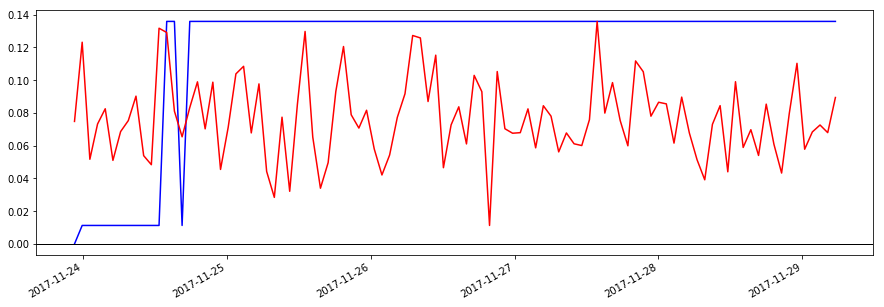

In [46]:
norm_price_data = binaryNormalized(btc_price_data, btc_chat_sent_min, btc_chat_sent_max)
                
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, btc_chat_sent_data, 0, 'r', p1)
p2.show()

## Price vs Sentiment
  -  Price Change normalized to mix-max sentiment
      - The price is normalized to show 0 (min sentiment) or 1 (max sentiment) 
      - Where its 1 or max when price is rising compared to the previous value 
      - For that the pivot param is set to true

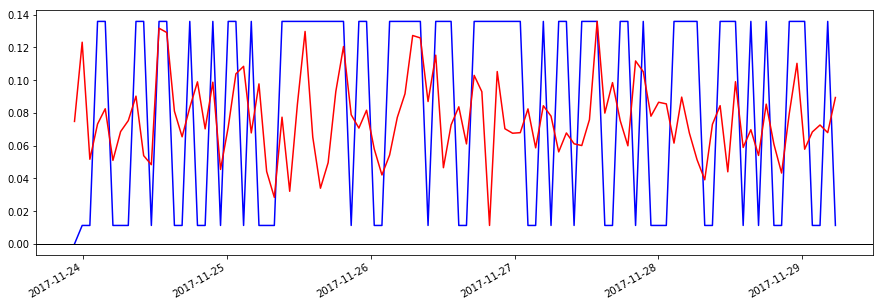

In [47]:
norm_price_data = binaryNormalized(btc_price_data, btc_chat_sent_min, btc_chat_sent_max, pivot=True)

p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, btc_chat_sent_data, 0, 'r', p1)
p2.show()

## Price vs Sentiment
  -  Price Change is normalized to mix-max sentiment

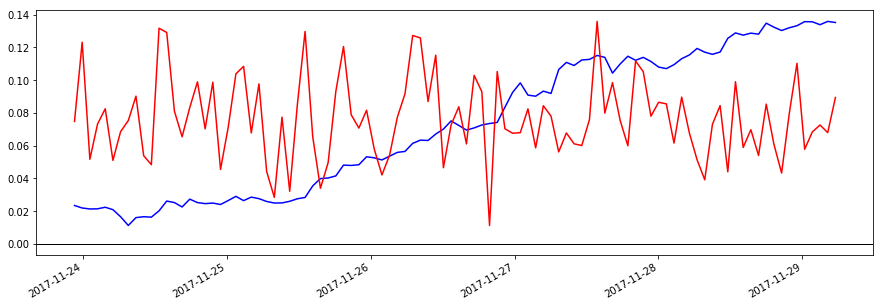

In [48]:
norm_price_data = normalisedData(btc_price_data, btc_chat_sent_min, btc_chat_sent_max)

p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, btc_chat_sent_data, 0, 'r', p1)
p2.show()

## Price vs Sentiment
  -  Sentiment Change is normalized to mix-max price

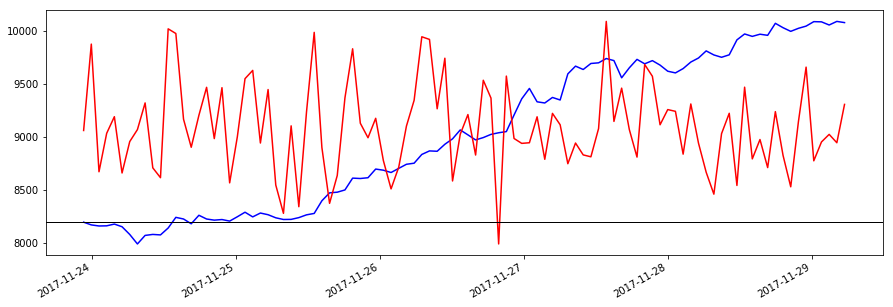

In [49]:
norm_sent_data = normalisedData(btc_chat_sent_data, btc_price_min, btc_price_max)

p1 = plotChart(time_data, btc_price_data, btc_price_data[0])
p2 = plotChart(time_data, norm_sent_data, btc_price_data[0], 'r', p1)
p2.show()

## Price vs Sentiment
  -  Price Change min-max normalized to range -10 to 10
      - The price is normalized to show -10 i.e min or 10 i.e max 
      - Where its 10 or max when price is rising compared to the fixed intial value 
      - Intital value is the price at the begning 
  -  Sentiment Change min-max normalized to range -5 to 5
      - The senitment is normalized to show -5 i.e min or 5 i.e max 
      - Where its 5 or max when sentiment is rising compared to the fixed intial value 
      - Intital value is the sentiment at the begning

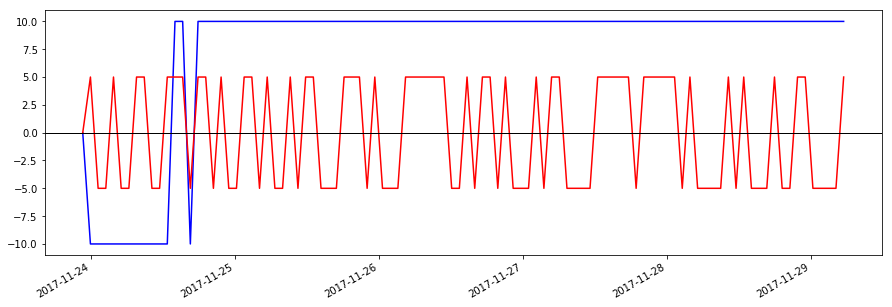

In [50]:
norm_price_data = binaryNormalized(btc_price_data, -10, 10)
norm_sent_data = binaryNormalized(btc_chat_sent_data, -5, 5)
    
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_sent_data, 0, 'r', p1)
p2.show()

## Price vs Sentiment
  -  Price Change min-max normalized to range -10 to 10
      - The price is normalized to show -10 i.e min or 10 i.e max 
      - Where its 10 or max when price is rising compared to the previous value 
      - For that the pivot param is set to true

  -  Sentiment Change min-max normalized to range -5 to 5
      - The senitment is normalized to show -5 i.e min or 5 i.e max 
      - Where its 5 or max when sentiment is rising compared to the fixed intial value 
      - Intital value is the sentiment at the begning

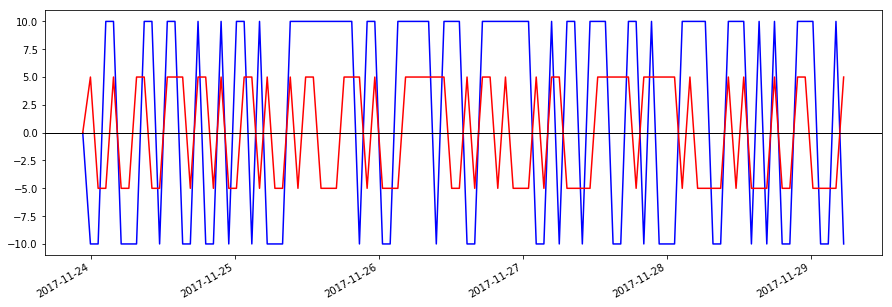

In [51]:
norm_price_data = binaryNormalized(btc_price_data, -10, 10, pivot=True)
norm_sent_data = binaryNormalized(btc_chat_sent_data, -5, 5)
    
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_sent_data, 0, 'r', p1)
p2.show()

## Price vs Sentiment
  -  Price Change normalized to percentage change
  -  Sentiment normalized to mix max percentage price change

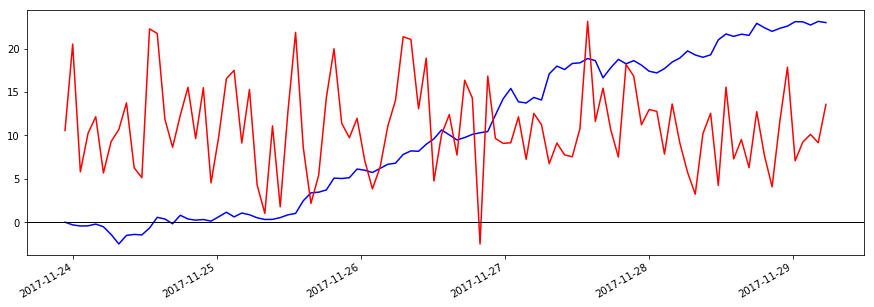

In [52]:
start_price = btc_price_data[0]
norm_price_data = [] 

for current_price in btc_price_data:
    delta = current_price - start_price
    norm_price_data.append(getPercentChange(delta, start_price))
    
norm_sent_data = normalisedData(btc_chat_sent_data, min(norm_price_data), max(norm_price_data))

p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_sent_data, 0, 'r', p1)
p2.show()

## Price vs Volume 
  -  Volume normalized to X times the min
  -  Price Change normalized to normalized volume min-max

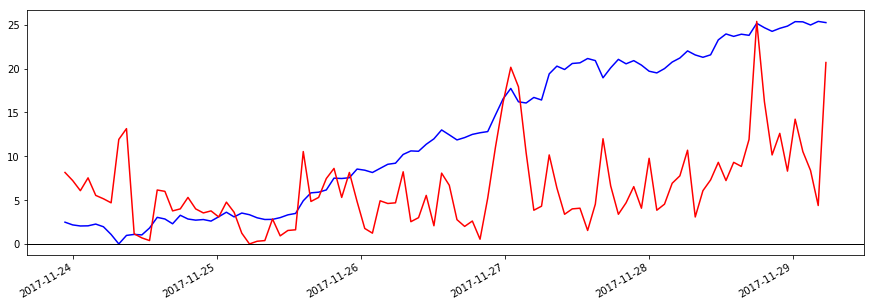

In [53]:
norm_volume_data = [] 
            
for current_volume in message_volume_data: 
    delta = current_volume - btc_chat_volume_min
    if delta > 0: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
    else: 
        if delta == 0: norm_volume_data.append(0) 
        else: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
                        
norm_price_data = normalisedData(btc_price_data, min(norm_volume_data), max(norm_volume_data))
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_volume_data, 0, 'r', p1)
p2.show()

## Price vs Volume
  -  Price Change normalized to mix-max X times volume
      - The price is normalized to show min volume or max volume
      - Where its max when price is rising compared to the fixed intial value 
      - Intital value is the price at the begning

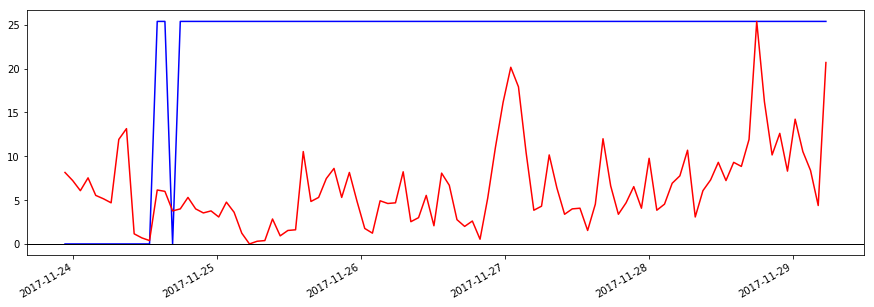

In [54]:
start_price = btc_price_data[0]
norm_price_data = [] 
norm_volume_data = [] 
            
for current_volume in message_volume_data: 
    delta = current_volume - btc_chat_volume_min
    if delta > 0: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
    else: 
        if delta == 0: norm_volume_data.append(0) 
        else: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
            
for current_price in btc_price_data: 
    delta = current_price - start_price
    if delta > 0: norm_price_data.append(max(norm_volume_data))
    else: 
        if delta == 0: norm_price_data.append(0) 
        else: norm_price_data.append(min(norm_volume_data))

                        
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_volume_data, 0, 'r', p1)
p2.show()

## Price vs Volume
  -  Price Change normalized to mix-max X times volume
      - The price is normalized to show min volume or max volume
      - Where its max when price is rising compared to the previous value 
      - For that the pivot param is set to true

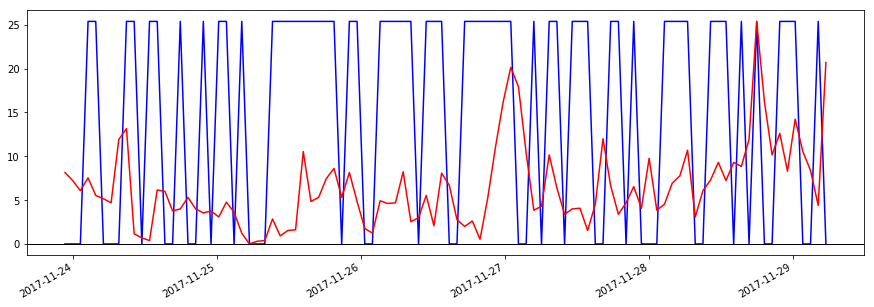

In [55]:
start_price = btc_price_data[0]
norm_price_data = [] 
norm_volume_data = [] 
previous = 0
            
for current_volume in message_volume_data: 
    delta = current_volume - btc_chat_volume_min
    if delta > 0: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
    else: 
        if delta == 0: norm_volume_data.append(0) 
        else: norm_volume_data.append((current_volume - btc_chat_volume_min) / btc_chat_volume_min)
                        
for current_price in btc_price_data: 
    if current_price - start_price > 0: 
        norm_price_data.append(max(norm_volume_data))
        previous = max(norm_volume_data)
    else:
        if current_price - start_price > 0: norm_price_data.append(previous)
        else: 
            norm_price_data.append(min(norm_volume_data))
            previous = max(norm_volume_data)
            
    start_price = current_price
                        
p1 = plotChart(time_data, norm_price_data, 0)
p2 = plotChart(time_data, norm_volume_data, 0, 'r', p1)
p2.show()